<h3><p align="center">导包</p></h3>

In [43]:
import cv2
import struct
import numpy as np
import matplotlib.pyplot as plt

<h3><p align="center">数据预处理</p></h3>

In [44]:
class DataGenerator():
    def __init__(self, mode='train', batch_size=1, vaild_ratio=0.2):
        '''
        mode:           该参数有两个选项 'train'和'test', 分别对应训练集的数据生成器和测试集的数据生成器
                        只有mode='train', 参数batch_size和vaild_ratio才是有效的
                        该参数默认为'train'

        batch_size:     当mode='train'时, 由参数batch_size指定训练过程中每次迭代要给模型输入多少个数据样本

        vaild_ratio:    当mode='train'时, 由参数vaild_ratio指定要从全部训练数据中取出多少作为验证集, 注意验证集一般不会参与训练
        '''
        self.mode = mode
        self.batch_size = batch_size
        self.vaild_ratio = vaild_ratio
        self.num_images = 0
        self.raw_images = []
        self.images = []
        self.labels = []
        assert mode in ['train', 'test']
        if mode == 'train':
            self.images_path = './mnist/train-images.idx3-ubyte'
            self.labels_path = './mnist/train-labels.idx1-ubyte'
        elif mode == 'test':
            self.images_path = './mnist/t10k-images.idx3-ubyte'
            self.labels_path = './mnist/t10k-labels.idx1-ubyte'
    def load_data(self):
        with open(self.images_path, 'rb') as imgpath:
            _, nums, rows, cols = struct.unpack('>IIII', imgpath.read(16))
            images = np.fromfile(imgpath, dtype=np.uint8).reshape(nums, rows*cols)
        with open(self.labels_path, 'rb') as lbpath:
            _, nums = struct.unpack('>II', lbpath.read(8))
            labels = np.fromfile(lbpath, dtype=np.uint8)
        self.num_images = nums
        self.images = [images[i] for i in range(nums)]
        self.labels = [labels[i] for i in range(nums)]
        self.raw_images = np.array(self.images.copy())
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)
    def getTrainIterator(self):
        assert self.mode == 'train'
        train_images = self.images[:int(self.num_images*(1-self.vaild_ratio))]
        train_labels = self.labels[:int(self.num_images*(1-self.vaild_ratio))]
        self.train_nums = train_images.shape[0]
        iter_num = int(np.ceil(self.train_nums / self.batch_size))
        iterator = iter([
                [
                    train_images[i*self.batch_size:(i+1)*self.batch_size], 
                    train_labels[i*self.batch_size:(i+1)*self.batch_size]
                ] for i in range(iter_num)
            ])
        return iterator
    def getValidIterator(self):
        assert self.mode == 'train'
        valid_images = self.images[int(self.num_images*(1-self.vaild_ratio)):]
        valid_labels = self.labels[int(self.num_images*(1-self.vaild_ratio)):]
        self.valid_nums = valid_images.shape[0]
        iter_num = self.valid_nums
        iterator = iter([
            [
                valid_images[i],
                valid_labels[i]
            ] for i in range(iter_num)
        ])
        return iterator
    def getTestIterator(self):
        assert self.mode == 'test'
        test_images = self.images
        test_labels = self.labels
        self.test_nums = test_images.shape[0]
        iter_num = self.test_nums
        iterator = iter([
            [
                test_images[i],
                test_labels[i]
            ] for i in range(iter_num)
        ])
        return iterator
    def shuffle(self):
        index = np.arange(self.num_images)
        np.random.shuffle(index)
        self.images, self.labels = self.images[index], self.labels[index]
    def normalize(self):
        images_max = np.max(self.images, axis=-1, keepdims=True)
        images_min = np.min(self.images, axis=-1, keepdims=True)
        self.images = (self.images - images_min) / (images_max - images_min)
    #def normalize(self):
    #    mean = np.mean(self.images)
    #    std =  np.std(self.images)
    #    self.images = (self.images - mean) / std


<h3><p align="center">激活函数及其导数</p></h3>

In [45]:
class Sigmoid():
    def forward(self, x):
        self.x = x
        y = 1.0 / (1.0 + np.exp(-x))
        self.y = y
        return self.y
    def backward(self, grad):
        dx = np.multiply(grad, np.multiply(self.y, 1-self.y))
        return dx

In [46]:
class Tanh():
    def forward(self, x):
        self.x = x
        y = 2.0 / (1.0 + np.exp(-2*self.x)) - 1.0
        self.y = y
        return y
    def backward(self, grad):
        dx = np.multiply(grad, 1 - np.multiply(self.y, self.y))
        return dx

In [47]:
class Softmax():
    def forward(self, x):
        self.x = x
        exp_x = np.exp(x)
        y = exp_x / exp_x.sum(axis=-1, keepdims=True)
        self.y = y
        return y
    def backward(self, grad):
        B, dim = self.x.shape
        dx = np.zeros((B, dim))
        for b in range(B):
            dx_curr = np.diag(self.y[b]) - np.outer(self.y[b], self.y[b])
            dx[b] = np.dot(grad[b], dx_curr)
        return dx

<h3><p align="center">交叉熵损失函数及其导数</p></h3>

In [48]:
class Softmax():
    def forward(self, x):
        exp_x = np.exp(x)
        y = exp_x / exp_x.sum(axis=1, keepdims=True)
        return y

In [49]:
class CrossEntropyLoss():
    def __init__(self):
        self.softmax = Softmax()
    def one_hot(self, labels, num_classes):
        one_hot_labels = np.eye(num_classes)[labels]
        return one_hot_labels
    def forward(self, logits, labels):
        self.logits = logits
        batch_size, num_classes = logits.shape
        one_hot_labels = self.one_hot(labels, num_classes)
        p = self.softmax.forward(self.logits)
        self.batch_size = batch_size
        self.labels = one_hot_labels
        self.p = p
        loss = np.sum(-one_hot_labels * np.log(p)) / self.batch_size
        return loss, p
    def backward(self):
        d_logits = (self.p - self.labels)
        return d_logits

<h3><p align="center">多层感知机及其导数</p></h3>

In [50]:
class Linear():
    def __init__(self, input_dim, output_dim):
        self.w = np.random.randn(input_dim, output_dim)
        self.b = np.random.randn(output_dim)
    def forward(self, x):
        self.x = x
        self.batch_size = self.x.shape[0]
        y = np.dot(x, self.w)
        y = y + self.b
        self.y = y
        return y
    def backward(self, grad):
        dw = np.dot(self.x.T, grad)
        db = np.sum(grad, axis=0)
        dx = np.dot(grad, self.w.T)
        self.dw = dw
        self.db = db
        return dx
    def update(self, lr):
        self.w = self.w - lr * self.dw / self.batch_size
        self.b = self.b - lr * self.db / self.batch_size

<h3><p align="center">分类器</p></h3>

In [51]:
class Classifier():
    def __init__(self, hp):
        self.hp = hp
        self.layer_1 = Linear(self.hp["input_dim"], self.hp["hidden_dim_1"])
        self.layer_2 = Linear(self.hp["hidden_dim_1"], self.hp["hidden_dim_2"])
        self.layer_3 = Linear(self.hp["hidden_dim_2"], self.hp["output_dim"])
        self.sigmoid = Sigmoid()
        self.tanh = Tanh()
        self.cross_entropy_loss = CrossEntropyLoss()
    def forward(self, x, y):
        h_1 = self.layer_1.forward(x)
        a_1 = self.sigmoid.forward(h_1)
        h_2 = self.layer_2.forward(a_1)
        a_2 = self.tanh.forward(h_2)
        h_3 = self.layer_3.forward(a_2)
        loss, p = self.cross_entropy_loss.forward(h_3, y)
        return loss, p
    def backward(self,):
        d_h_3 = self.cross_entropy_loss.backward()
        d_a_2 = self.layer_3.backward(d_h_3)
        d_h_2 = self.tanh.backward(d_a_2)
        d_a_1 = self.layer_2.backward(d_h_2)
        d_h_1 = self.sigmoid.backward(d_a_1)
        d_x = self.layer_1.backward(d_h_1)
    def update(self):
        lr = self.hp["lr"]
        self.layer_1.update(lr)
        self.layer_2.update(lr)
        self.layer_3.update(lr)

<h3><p align="center">训练</p></h3>

In [79]:
hp = {
    "lr": 1e-1,
    "batch_size": 16,
    "valid_ratio": 0.1,
    "epochs": 40,
    "input_dim": 784,
    "hidden_dim_1": 64,
    "hidden_dim_2": 16,
#    "hidden_dim_1": 128,
#    "hidden_dim_2": 32,
#    "hidden_dim_1": 256,
#    "hidden_dim_2": 64,
    "output_dim": 10,
}

In [80]:
train_data_generator = DataGenerator(
        mode="train", 
        batch_size=hp["batch_size"], 
        vaild_ratio=hp["valid_ratio"]
    )
train_data_generator.load_data()

In [81]:
train_data_generator.images = train_data_generator.images[:50000]
train_data_generator.labels = train_data_generator.labels[:50000]
train_data_generator.num_images = 50000
train_data_generator.normalize()

In [82]:
test_data_generator = DataGenerator(mode="test", batch_size=1)
test_data_generator.load_data()

In [83]:
test_data_generator.images = test_data_generator.images[:10000]
test_data_generator.labels = test_data_generator.labels[:10000]
test_data_generator.num_images = 10000
test_data_generator.normalize()

In [84]:
classifier = Classifier(hp)

[epoch 0] [training ...]
[epoch 1] [training ...]
[epoch 2] [training ...]
[epoch 3] [training ...]
[epoch 4] [training ...]
[epoch 5] [training ...]
[epoch 6] [training ...]
[epoch 7] [training ...]
[epoch 8] [training ...]
[epoch 9] [training ...]
[epoch 10] [training ...]
[epoch 11] [training ...]
[epoch 12] [training ...]
[epoch 13] [training ...]
[epoch 14] [training ...]
[epoch 15] [training ...]
[epoch 16] [training ...]
[epoch 17] [training ...]
[epoch 18] [training ...]
[epoch 19] [training ...]
[epoch 20] [training ...]
[epoch 21] [training ...]
[epoch 22] [training ...]
[epoch 23] [training ...]
[epoch 24] [training ...]
[epoch 25] [training ...]
[epoch 26] [training ...]
[epoch 27] [training ...]
[epoch 28] [training ...]
[epoch 29] [training ...]
[epoch 30] [training ...]
[epoch 31] [training ...]
[epoch 32] [training ...]
[epoch 33] [training ...]
[epoch 34] [training ...]
[epoch 35] [training ...]
[epoch 36] [training ...]
[epoch 37] [training ...]
[epoch 38] [training .

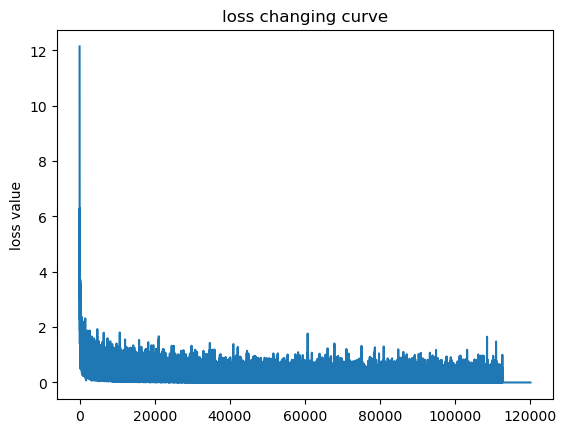

In [85]:
loss_val=np.zeros(120000)
j = 0
for epoch in range(hp["epochs"]):
    train_data_generator.shuffle()
    train_iter = train_data_generator.getTrainIterator()
    for images, labels in train_iter:
        loss, pred = classifier.forward(images, labels)
        classifier.backward()
        classifier.update()
        loss_val[j]=loss
        j += 1
    print("[epoch {}] [training ...]".format(epoch))
x=np.arange(120000)
plt.figure()
plt.plot(x,loss_val)
plt.ylabel('loss value')
plt.title('loss changing curve')
plt.show()

In [86]:
test_acc = 0
test_iter = test_data_generator.getTestIterator()
for images, labels in test_iter:
    loss, pred = classifier.forward(images.reshape(1, -1), labels)
    pred = pred.argmax(axis=1)
    if pred == labels:
        test_acc += 1
test_acc = test_acc / test_data_generator.test_nums
print("[test] acc: {}".format(test_acc))

[test] acc: 0.9118


<h3><p align="center">手写图像测试</p></h3>

In [87]:
image = cv2.imread('./test/1.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image,(28,28), interpolation=cv2.INTER_CUBIC)
cv2.imwrite('./test/1.png',image)
img = np.reshape(image,[1,784])

In [88]:
np.seterr(divide='ignore',invalid='ignore')
img_max = np.max(img, axis=-1, keepdims=True)
img_min = np.min(img, axis=-1, keepdims=True)
img_res = (img - img_min) / (img - img_min)
loss_mytest,pred_mytest = classifier.forward(img_res.reshape(1, -1), None)
pred_mytest = pred_mytest.argmax(axis=1)
print('Num: ', pred_mytest)

Num:  [0]
